<h1>Research Papers analytics summary</h1>
<p>In this notebook, we will explore of what can the research paper tell us.</p>

In [6]:
#Import packages and data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import codecs
import re
import os
from bs4 import BeautifulSoup # $ pip install beautifulsoup4
from wordcloud import WordCloud
%matplotlib inline
paper_df = pd.read_csv('../dataset/cleaned_papers_pdf.csv',encoding='utf-8')

<h1>Data Exploration</h1>

In [10]:
print(paper_df.shape)

(784, 5)


Our data has 784 papers and 5 columns.

<h2>Let's look at some example of row in data</h2>

In [8]:
paper_df.head()

,name,content,directory,isValid,faculty
0,Banlue Srisuchinwong,"Thammasat Int. J. Sc. Tech., Vol.6, No.l, Janu...",../papers/ICT_professor/Banlue Srisuchinwong/1...,True,ICT_professor
1,Banlue Srisuchinwong,___________________________________________0-7...,../papers/ICT_professor/Banlue Srisuchinwong/1...,True,ICT_professor
2,Banlue Srisuchinwong,This paper is a postprint of a paper submitted...,../papers/ICT_professor/Banlue Srisuchinwong/2...,True,ICT_professor
3,Banlue Srisuchinwong,Electronic version of an article published as ...,../papers/ICT_professor/Banlue Srisuchinwong/2...,True,ICT_professor
4,Banlue Srisuchinwong,PhysicsLettersA373(2009)4038–4043 Contentslist...,../papers/ICT_professor/Banlue Srisuchinwong/2...,True,ICT_professor


<h4>Each row represent one research paper.</h4>

Columns Meaning
<ol>
<li>Name: Paper writer name</li>
<li>Content: content in papers extracted from pdf file</li>
<li>Directory: directory of paper pdf</li>
<li>Faculty: Faculty of professor in SIIT</li>
</ol>

<h3>Let's see number of paper group by faculty</h3>

In [4]:
paper_df['faculty'].value_counts()

ICT_professor    588
MSME             196
Name: faculty, dtype: int64

<p>At the moment there are more papers from ICT professor.</p> 
<p>**Note**</p>
<p>ICT: Computer and Communication Technology</p>
<p>MSME: Manufacturing Systems and Mechanical Engineering</p>

<h1>Creating Bag of Words Model</h1>
<p>Next we will embed our data to bag of words model. So that we can somehow see relation between each papers.</p>

In [14]:
#Preprocess data for bag of words model
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
def content_to_words( paper_content ):      
    letters_only = re.sub("[^a-zA-Z]", " ", paper_content) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))      
    paper_stop = ['cid','fig','however','respectively','used','therefore']
    stops |= set(paper_stop)
    meaningful_words = [w for w in words if not w in stops] 
    wordnet_lemmatizer = WordNetLemmatizer()
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words if len(w)!=1 or w in['a','i','u']]
    return( " ".join( meaningful_words ))   
#Cleaning the data
paper_df['cleaned_content'] = paper_df['content'].apply(content_to_words)

In [16]:
#Creating Bags of Words
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) 

train_data_features = vectorizer.fit_transform(paper_df['cleaned_content'])
print("Bag of words created")

Creating the bag of words...

Bag of words created


<h2>Let's see some of the most frequent word used by professors</h2>

In [18]:
freqs = [(word, train_data_features.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
#sort from largest to smallest
print(sorted(freqs, key = lambda x: -x[1])[0:10])

[('system', 10539), ('figure', 8363), ('time', 7390), ('model', 6800), ('table', 6489), ('result', 6348), ('method', 6235), ('pp', 6128), ('based', 6047), ('data', 5788)]


<h2>Next, map bag of words into 2 dimensional array.</h2>
<p>This way, we can graph it into 2d graph.</p>

In [20]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=450, random_state=42)
reduced_X = svd.fit_transform(train_data_features) 

<h3>Done! Now let's graph all of the research paper.</h3>

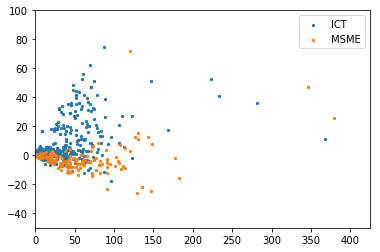

In [26]:
ICT_Professors = reduced_X[paper_df['faculty']=='ICT_professor'] 
x,y = ICT_Professors.T
plt.scatter(x,y,s=5,label='ICT')
MSME_Professors = reduced_X[paper_df['faculty']=='MSME']
x,y = MSME_Professors.T
plt.scatter(x,y,s=5,label='MSME')
plt.legend()
plt.xlim((0,425))
plt.ylim((-50,100))
plt.show()

<h3>Scatter Plot created!</h3>
<ol>
<li>x and y axis of this scatter plot has no real meaning. The only semantic things we can get from here is that near dot are more similar.</li>
<li>As you might see, paper from ICT and MSME is seperated (not cleanly because there are some overlapped word between the two).</li>
</ol>

<h2>Word Cloud</h2>
<p>We can also create wordcloud from the papers to see which word occur the most.</p>

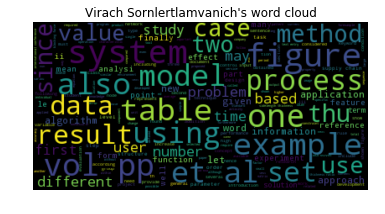

In [31]:
from wordcloud import WordCloud
def professor_wordCloud(name):
    text = ''
    professor_pdf = paper_df[paper_df['name']==name]
    for i,row in paper_df.iterrows():
        text+=(row['cleaned_content']+"\n")
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(name+"'s word cloud")
    plt.show()
    
professor_wordCloud('Virach Sornlertlamvanich')  #ICT professor

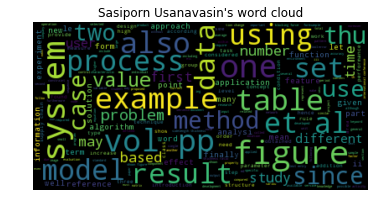

In [32]:
professor_wordCloud('Sasiporn Usanavasin')    #ICT professor

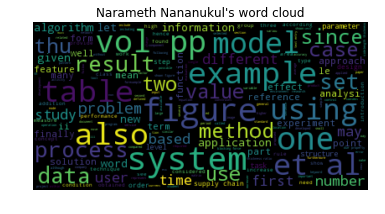

In [36]:
professor_wordCloud('Narameth Nananukul')    #MSME professor

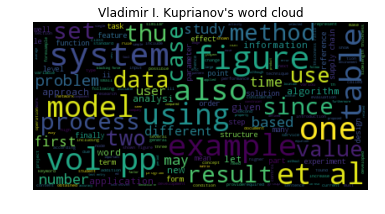

In [37]:
professor_wordCloud('Vladimir I. Kuprianov')    #MSME professor

<h3>Improving bag of words model</h3>
<p>In bag of words, we only consider frequency of each word. Let's also consider how rare each word is. If the word occured only in on paper, that word tend to be strong (important) to that paper. This is called Document Frequency.</p>

<p>**The imeplementation of tf/idf will be skipped in this notebook becauyse it is similar to above example but only with differet result. If interested you can find them in another python notebook called "Paper Analytics with tf-idf.ipynb" available in github**</p>

<h1>Word2Vec</h1>
<p>We can also find word with similar meaning using word2vec technique.</p><p> Word2Vec tried to create vector for each of the word based on their semantics. If two word has similar meaning, the vector will be close to each other.</p>

<h3>We have to convert the content of each paper into the format that word2vec library want. You can just ignore these if you want.</h3>

In [38]:
def review_to_wordlist( paper_content ):
    letters_only = re.sub("[^a-zA-Z]", " ", paper_content) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))      
    stops.add('cid')
    meaningful_words = [w for w in words if not w in stops] 
    meaningful_words = [w for w in meaningful_words if len(w)!=1 or w in['a','i','u']]
    return( " ".join( meaningful_words ))   

# Download the punkt tokenizer for sentence splitting  
import nltk
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
from nltk.corpus import stopwords # Import the stop word list
def paper_to_sentences( review, tokenizer, remove_stopwords=False ):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
         if len(raw_sentence) > 0:
            sentences.append( review_to_wordlist( raw_sentence))
    return sentences

In [40]:
sentences = []  # Initialize an empty list of sentences
print("Parsing sentences from training set")
for paper in paper_df["content"]:
    sentences += paper_to_sentences(paper, tokenizer)
print("Finished parsing")

Parsing sentences from training set
Finished parsing


In [42]:
split_sentences = [sentence.split(" ") for sentence in sentences if len(sentence)>1]

In [44]:
# Set values for various parameters
num_features = 500    # Word vector dimensionality                      
min_word_count = 0  # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(split_sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
print("Trainined")

Training model...
Trainined


<h2>Word2Vec model created. </h2>
<p>Let's try to find some word similar to 'database'</p>

In [45]:
model.most_similar('database')

[('directory', 0.9827893376350403),
 ('server', 0.9799363017082214),
 ('addresssuch', 0.9731322526931763),
 ('store', 0.9700136780738831),
 ('oolong', 0.9680442810058594),
 ('gathered', 0.9662722945213318),
 ('video', 0.9661882519721985),
 ('files', 0.9654984474182129),
 ('unl', 0.9642136096954346),
 ('wikipedia', 0.9641373157501221)]

Try with other word

In [46]:
model.most_similar('corpus')

[('code', 0.9725058078765869),
 ('statistics', 0.9712008237838745),
 ('extracting', 0.9707172513008118),
 ('bracketed', 0.9626898765563965),
 ('specifications', 0.9607688188552856),
 ('testing', 0.9603278636932373),
 ('xml', 0.959742546081543),
 ('reference', 0.9587292671203613),
 ('training', 0.9580082893371582),
 ('dialog', 0.956508219242096)]

In [47]:
model.most_similar('semantic')

[('keywords', 0.9782457947731018),
 ('tual', 0.9759352207183838),
 ('extracting', 0.9717134237289429),
 ('named', 0.971229612827301),
 ('linguistic', 0.9706254601478577),
 ('exploiting', 0.9686877131462097),
 ('slation', 0.964697003364563),
 ('translation', 0.9637066125869751),
 ('extraction', 0.9632284045219421),
 ('sensed', 0.9629933834075928)]

In [49]:
model.most_similar('tensile')

[('curvatures', 0.9902904033660889),
 ('chamber', 0.9882720708847046),
 ('subsonic', 0.9877241253852844),
 ('hcg', 0.9869945645332336),
 ('clarity', 0.9850644469261169),
 ('ceiling', 0.9847411513328552),
 ('trc', 0.9846451878547668),
 ('substrate', 0.9843689203262329),
 ('diffuser', 0.9831932187080383),
 ('zncc', 0.983141303062439)]

These are some of the example of what we can do with the research paper data. There are much more things to explore.